# Imports

In [1]:
from sre_parse import Tokenizer
import zipfile

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_precision_recall
from scikitplot.estimators import plot_feature_importances


import langdetect
from cleantext import clean
from imblearn.over_sampling import RandomOverSampler

import gensim.downloader as api

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences


# Checking GPU

In [2]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))


2.10.0
Num GPUs Available:  1


# Setting seeds

In [3]:
seed = 42
langdetect.DetectorFactory = seed
np.random.seed = seed


# Constants and hyperparameters

In [4]:
BATCH_SIZE = 64
EPOCHS = 100


# Downloading dataset

In [5]:
!kaggle datasets download -d advaypatil/youtube-statistics

youtube-statistics.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
dataset = zipfile.ZipFile("youtube-statistics.zip")
dataset.extractall("dataset")


# Loading data to dataframe

In [7]:
df = pd.read_csv("dataset/comments.csv")


In [8]:
df.head(5)


,Unnamed: 0,Video ID,Comment,Likes,Sentiment
0,0,wAZZ-UWGVHI,Let's not forget that Apple Pay in 2014 requir...,95.0,1.0
1,1,wAZZ-UWGVHI,Here in NZ 50% of retailers don’t even have co...,19.0,0.0
2,2,wAZZ-UWGVHI,I will forever acknowledge this channel with t...,161.0,2.0
3,3,wAZZ-UWGVHI,Whenever I go to a place that doesn’t take App...,8.0,0.0
4,4,wAZZ-UWGVHI,"Apple Pay is so convenient, secure, and easy t...",34.0,2.0


# Adding a column with information about language of comment

In [9]:
def add_languge(row):
    try:
        lang = langdetect.detect(row)
    except:
        lang = np.nan
    return lang


df["lang"] = df["Comment"].apply(add_languge)
df.sample(5)


,Unnamed: 0,Video ID,Comment,Likes,Sentiment,lang
179,179,qiMnSaZWf3M,I like the engraver but when I went to check p...,13.0,1.0,en
17556,17556,66SKA06jouw,Fantastic game with seemingly endless potentia...,142.0,2.0,en
1753,1753,ZzLPUoetSHw,Fantastic content! Taka has such a warm and in...,2239.0,2.0,en
4193,4193,axyNCiXeym8,Rubik's cube logic you repeat same moves it wi...,1712.0,1.0,en
9945,9945,L_U7b1aWPY4,Pin me pliss I Love you 💘,14437.0,2.0,fr


In [10]:
df = df.dropna()
df = df.loc[df["lang"] == "en"]
print(df["lang"].unique())
print(df["Comment"].isna().any())


['en']
False


In [11]:
df.sample(5)


,Unnamed: 0,Video ID,Comment,Likes,Sentiment,lang
14115,14115,v-aP1J-BdvE,"Can't help but quote Douglas Adams: ""There is ...",452.0,0.0,en
6778,6778,4RCFLobfqcw,"I'm reading ""The secret garden"" right now and ...",20.0,2.0,en
13644,13644,6v8djXa-IPQ,Thank you for helping beginners understand sci...,7.0,2.0,en
4435,4435,gwKFZlyZ99E,It always makes me laugh when mark gives one r...,6707.0,2.0,en
17036,17036,fUpChfNN5Uo,Amazing video Alex! Can't believe I'm just wat...,124.0,2.0,en


# Splitting dataset to X and y variables

In [12]:
X = df.drop(columns=["Unnamed: 0", "Video ID", "Likes", "Sentiment", "lang"])
y = df["Sentiment"].astype(int)


In [13]:
y.value_counts()


2    10693
1     3333
0     2300
Name: Sentiment, dtype: int64

### In dataset there is information about our y:
> *A value of zero represents a negative sentiment, whereas values of 
> one and two represent neutral*

Because of that I am changing all values from "2" to "1".

(https://www.kaggle.com/datasets/advaypatil/youtube-statistics)


In [14]:
y_binary = y.apply(lambda x: np.where(x >= 1, 1, 0))
y_binary.value_counts()


1    14026
0     2300
Name: Sentiment, dtype: int64

## Splitting dataset to training and test data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.2, random_state=seed
)
len(X_train), len(X_test), len(y_train), len(y_test)


(13060, 3266, 13060, 3266)

In [16]:
X_train.sample(10)


,Comment
7414,Love diamonds bedroom 🧋💍 it’s so shiny and bea...
11895,*28:58*\n*Let’s just appreciate how they alway...
13596,"Son: \n""Mom, can I attend a biology class?""\n\..."
1869,Wow! That is fantastic! Thank you for sharing ...
9270,The fact that Rhett doesn’t like big shrimp th...
16077,"When Groot said ""It's Grootin' time"" I fell in..."
11171,"The orchestra looks like they are enjoying it,..."
9164,I've hated Calzone until the day I made it by ...
14757,Just passing by to say that I'm loving her cou...
16428,It's finally here. Drop a like if you're hyped...


### We can see that our data are imbalanced. We will use ***imblearn*** to deal with it. 

In [17]:
y_train.value_counts()


1    11235
0     1825
Name: Sentiment, dtype: int64

In [18]:
oversample = RandomOverSampler(sampling_strategy="minority")
X_over, y_over = oversample.fit_resample(X_train, y_train)


In [19]:
len(X_over), len(y_over), y_over.value_counts()


(22470,
 22470,
 1    11235
 0    11235
 Name: Sentiment, dtype: int64)

In [20]:
X_over


,Comment
0,I watched this a year ago. It completely chang...
1,Thank you for this super interesting video! :)...
2,We need more music pls -> 48h playlist :)
3,Chandler is literally the funniest person and ...
4,Imagine being a scammer and get hurt because s...
...,...
22465,Got chills 🥶 they don’t make timeless music li...
22466,i promised myself months ago i'd start studyin...
22467,How many people out there would have several ...
22468,Canelo and Plants speech gave me the chills ma...


# Removing emoticons and other unwanted characters

In [21]:
def clean_text(data):
    data = data.apply(
        lambda x: clean(x, no_emoji=True, no_line_breaks=True, no_punct=True)
    )
    return data


X_train_cleaned = clean_text(X_over["Comment"])
X_train_cleaned.sample(5)


21457    online chess is far inferior to normal chess i...
16754    as a former military officer myself i cannot f...
4906     i wish developers would realize that forced dr...
22168    it blows my mind that people are on the intern...
845      more from this series like rome egypt etc this...
Name: Comment, dtype: object

In [22]:
X_test_cleaned = clean_text(X_test["Comment"])


In [23]:
max_words_in_sentence = 150
max_words_in_vocab = 20_000

tokenizer = Tokenizer(oov_token="UNK", num_words=max_words_in_vocab)
tokenizer.fit_on_texts(X_train_cleaned)

X_train_seq = tokenizer.texts_to_sequences(X_train_cleaned)
X_train_seq[0]


[6,
 470,
 13,
 5,
 159,
 257,
 12,
 415,
 940,
 15,
 132,
 98,
 2888,
 7,
 886,
 88,
 7,
 1446,
 11200,
 319,
 886,
 15634,
 7,
 1238,
 98,
 6159,
 10088,
 47,
 3,
 15,
 6160,
 427,
 836,
 15,
 442,
 44,
 2,
 10089,
 7,
 15635,
 95,
 2027,
 15636,
 173,
 47,
 344,
 27,
 77,
 927,
 272,
 136,
 13,
 725,
 8278,
 303,
 3,
 2,
 1039]

In [24]:
X_test_seq = tokenizer.texts_to_sequences(X_test_cleaned)


In [25]:
X_train_padded = pad_sequences(
    X_train_seq, maxlen=max_words_in_sentence, padding="post"
)
X_train_padded[0]


array([    6,   470,    13,     5,   159,   257,    12,   415,   940,
          15,   132,    98,  2888,     7,   886,    88,     7,  1446,
       11200,   319,   886, 15634,     7,  1238,    98,  6159, 10088,
          47,     3,    15,  6160,   427,   836,    15,   442,    44,
           2, 10089,     7, 15635,    95,  2027, 15636,   173,    47,
         344,    27,    77,   927,   272,   136,    13,   725,  8278,
         303,     3,     2,  1039,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [26]:
len(y_over)


22470

In [27]:
print(len(X_train_padded))


22470


In [28]:
X_test_padded = pad_sequences(X_test_seq, maxlen=max_words_in_sentence, padding="post")


# Downloading GloVe embeddings

In [29]:
glove = api.load("glove-wiki-gigaword-200")


## Preparing embeddings

In [30]:
words_embeddings = np.zeros((max_words_in_vocab + 1, 200))


In [31]:
for word, index in tokenizer.word_index.items():
    try:
        vector = glove.get_vector(word)
        words_embeddings[index] = vector
    except KeyError as e:
        print(f"Error: {e}")

    if index == len(words_embeddings) - 1:
        break


Error: "Key 'UNK' not present"
Error: "Key 'youve' not present"
Error: "Key 'lmao' not present"
Error: "Key 'werent' not present"
Error: "Key 'theyve' not present"
Error: "Key 'asmr' not present"
Error: "Key 'shouldnt' not present"
Error: "Key 'wouldve' not present"
Error: "Key 'lofi' not present"
Error: "Key 'itll' not present"
Error: "Key 'gamepass' not present"
Error: "Key 'viserys' not present"
Error: "Key 'httpswwwyoutubecomwatchv' not present"
Error: "Key 'splatoon' not present"
Error: "Key 'qiyi' not present"
Error: "Key 'theyd' not present"
Error: "Key 'shouldve' not present"
Error: "Key 'denuvo' not present"
Error: "Key 'idk' not present"
Error: "Key 'binance' not present"
Error: "Key 'casemiro' not present"
Error: "Key 'mrbeast' not present"
Error: "Key 'mongo316' not present"
Error: "Key 'covid' not present"
Error: "Key 'pyraminx' not present"
Error: "Key 'pumpspumped' not present"
Error: "Key 'pumpsnarrowly' not present"
Error: "Key 'tradiing' not present"
Error: "Key 'trad

# Creating a model without recurrent layers

In [32]:
model_no_rnn = Sequential()
model_no_rnn.add(
    Embedding(
        max_words_in_vocab + 1,
        200,
        weights=[words_embeddings],
        input_length=max_words_in_sentence,
        trainable=False,
    )
)
model_no_rnn.add(Flatten())
model_no_rnn.add(Dense(64, activation="relu"))
model_no_rnn.add(Dropout(0.2))
model_no_rnn.add(Dense(32, activation="relu"))
model_no_rnn.add(Dropout(0.3))
model_no_rnn.add(Dense(16, activation="relu"))
model_no_rnn.add(Dropout(0.5))
model_no_rnn.add(Dense(1, activation="sigmoid"))


In [33]:
model_no_rnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
print(model_no_rnn.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 200)          4000200   
                                                                 
 flatten (Flatten)           (None, 30000)             0         
                                                                 
 dense (Dense)               (None, 64)                1920064   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                5

# Creating a model with recurrent layer

In [34]:
model_rnn = Sequential()
model_rnn.add(
    Embedding(
        max_words_in_vocab + 1,
        200,
        weights=[words_embeddings],
        input_length=max_words_in_sentence,
        trainable=False,
    )
)
model_rnn.add(LSTM(64, return_sequences=False))
model_rnn.add(Dense(1, activation="sigmoid"))


In [35]:
model_rnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
print(model_rnn.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 200)          4000200   
                                                                 
 lstm (LSTM)                 (None, 64)                67840     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,068,105
Trainable params: 67,905
Non-trainable params: 4,000,200
_________________________________________________________________
None


# Training models

## Without recurrent layers

In [36]:
filepath = "models/model_no_rnn.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor="val_loss", verbose=1, save_best_only=True, mode="min"
)
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
callbacks_list = [checkpoint, es]

model_no_rnn.fit(
    X_train_padded,
    y_over,
    validation_split=0.2,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks_list,
)


Epoch 1/100
276/281 [============================>.] - ETA: 0s - loss: 0.5860 - accuracy: 0.6739
Epoch 1: val_loss improved from inf to 0.71591, saving model to models\model_no_rnn.h5
281/281 [==============================] - 3s 4ms/step - loss: 0.5831 - accuracy: 0.6765 - val_loss: 0.7159 - val_accuracy: 0.7043
Epoch 2/100
271/281 [===========================>..] - ETA: 0s - loss: 0.3615 - accuracy: 0.8510
Epoch 2: val_loss improved from 0.71591 to 0.25241, saving model to models\model_no_rnn.h5
281/281 [==============================] - 1s 3ms/step - loss: 0.3600 - accuracy: 0.8520 - val_loss: 0.2524 - val_accuracy: 0.9526
Epoch 3/100
269/281 [===========================>..] - ETA: 0s - loss: 0.2315 - accuracy: 0.9113
Epoch 3: val_loss did not improve from 0.25241
281/281 [==============================] - 1s 3ms/step - loss: 0.2302 - accuracy: 0.9115 - val_loss: 0.2552 - val_accuracy: 0.9110
Epoch 4/100
278/281 [============================>.] - ETA: 0s - loss: 0.1611 - accuracy: 0

## With reccurent layer

In [37]:
filepath = "models/model_rnn.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor="val_loss", verbose=1, save_best_only=True, mode="min"
)
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
callbacks_list = [checkpoint, es]

model_rnn.fit(
    X_train_padded,
    y_over,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=callbacks_list,
)


Epoch 1/100
277/281 [============================>.] - ETA: 0s - loss: 0.6624 - accuracy: 0.6271
Epoch 1: val_loss improved from inf to 0.93315, saving model to models\model_rnn.h5
281/281 [==============================] - 8s 16ms/step - loss: 0.6623 - accuracy: 0.6271 - val_loss: 0.9331 - val_accuracy: 0.0109
Epoch 2/100
277/281 [============================>.] - ETA: 0s - loss: 0.6587 - accuracy: 0.6293
Epoch 2: val_loss did not improve from 0.93315
281/281 [==============================] - 4s 14ms/step - loss: 0.6587 - accuracy: 0.6294 - val_loss: 1.0077 - val_accuracy: 0.0229
Epoch 3/100
278/281 [============================>.] - ETA: 0s - loss: 0.6554 - accuracy: 0.6323
Epoch 3: val_loss did not improve from 0.93315
281/281 [==============================] - 4s 14ms/step - loss: 0.6554 - accuracy: 0.6323 - val_loss: 0.9957 - val_accuracy: 0.0409
Epoch 4/100
277/281 [============================>.] - ETA: 0s - loss: 0.6535 - accuracy: 0.6348
Epoch 4: val_loss did not improve from

# Loading saved models

In [38]:
model_rnn = tf.keras.models.load_model("models/model_rnn.h5")
model_no_rnn = tf.keras.models.load_model("models/model_no_rnn.h5")


# Evaluating models

In [39]:
rnn_eval = model_rnn.evaluate(X_test_padded, y_test)
no_rnn_eval = model_no_rnn.evaluate(X_test_padded, y_test)


103/103 [==============================] - 0s 1ms/step - loss: 3.3818 - accuracy: 0.8622


In [40]:
rnn_train_pred = model_rnn.predict(X_train_padded)
no_rnn_train_pred = model_no_rnn.predict(X_train_padded)

rnn_test_pred = model_rnn.predict(X_test_padded)
no_rnn_test_pred = model_no_rnn.predict(X_test_padded)


103/103 [==============================] - 0s 853us/step


In [41]:
rnn_train_pred = np.where(rnn_train_pred > 0.5, 1, 0)
no_rnn_train_pred = np.where(no_rnn_train_pred > 0.5, 1, 0)

rnn_test_pred = np.where(rnn_test_pred > 0.5, 1, 0)
no_rnn_test_pred = np.where(no_rnn_test_pred > 0.5, 1, 0)


## Accuracy

### Training data

In [42]:
print("RNN train acc: ", accuracy_score(y_true=y_over, y_pred=rnn_train_pred))
print("No RNN train acc: ", accuracy_score(y_true=y_over, y_pred=no_rnn_train_pred))


RNN train acc:  0.9991989319092123
No RNN train acc:  0.9997774810858923


### Test data

In [43]:
print("RNN test acc: ", accuracy_score(y_true=y_test, y_pred=rnn_test_pred))
print("No RNN test acc: ", accuracy_score(y_true=y_test, y_pred=no_rnn_test_pred))


RNN test acc:  0.8784445805266381
No RNN test acc:  0.8622167789344765


## Precision

### Training data

In [44]:
print("RNN train precision: ", precision_score(y_true=y_over, y_pred=rnn_train_pred))
print(
    "No RNN train precision: ", precision_score(y_true=y_over, y_pred=no_rnn_train_pred)
)


RNN train precision:  0.9991100827623031
No RNN train precision:  1.0


### Test data

In [45]:
print("RNN test precision: ", precision_score(y_true=y_test, y_pred=rnn_test_pred))
print(
    "No RNN test precision: ", precision_score(y_true=y_test, y_pred=no_rnn_test_pred)
)


RNN test precision:  0.9127586206896552
No RNN test precision:  0.8913406887328653


## Recall

### Training data

In [46]:
print("RNN test recall: ", recall_score(y_true=y_over, y_pred=rnn_train_pred))
print("No RNN test recall: ", recall_score(y_true=y_over, y_pred=no_rnn_train_pred))


RNN test recall:  0.9992879394748554
No RNN test recall:  0.9995549621717846


### Test data

In [47]:
print("RNN test recall: ", recall_score(y_true=y_test, y_pred=rnn_test_pred))
print("No RNN test recall: ", recall_score(y_true=y_test, y_pred=no_rnn_test_pred))


RNN test recall:  0.9484055893944823
No RNN test recall:  0.9552131852382658


## Confusion matrix

### Training data

<AxesSubplot: title={'center': 'RNN'}, xlabel='Predicted label', ylabel='True label'>

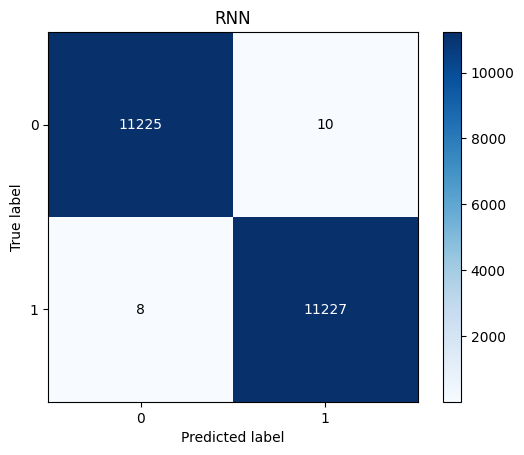

In [48]:
plot_confusion_matrix(y_true=y_over, y_pred=rnn_train_pred, title="RNN")

<AxesSubplot: title={'center': 'No RNN'}, xlabel='Predicted label', ylabel='True label'>

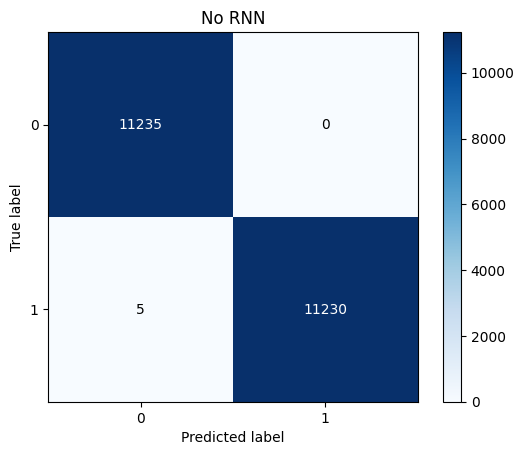

In [49]:
plot_confusion_matrix(y_true=y_over, y_pred=no_rnn_train_pred, title="No RNN")

### Test data

<AxesSubplot: title={'center': 'RNN'}, xlabel='Predicted label', ylabel='True label'>

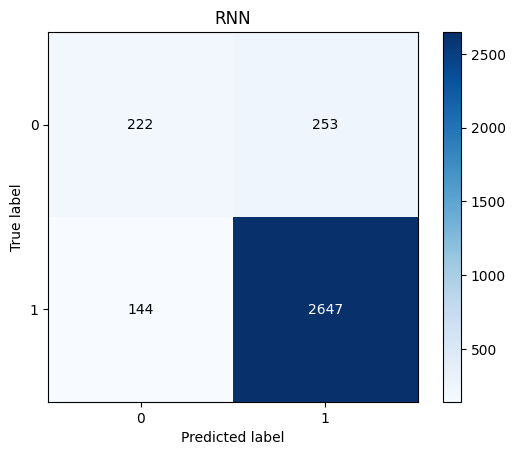

In [50]:
plot_confusion_matrix(y_true=y_test, y_pred=rnn_test_pred, title="RNN")

<AxesSubplot: title={'center': 'No RNN'}, xlabel='Predicted label', ylabel='True label'>

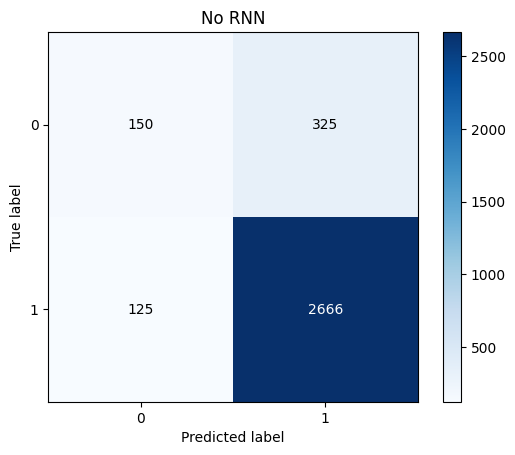

In [51]:
plot_confusion_matrix(y_true=y_test, y_pred=no_rnn_test_pred, title="No RNN")

### My own test

In [52]:
positive = "Guess I've never seen someone so genuine and joyful. Thank you for making me laugh."
negative = "Terrible video. Stop recording and do something useful"

In [53]:
positive_tokenized = tokenizer.texts_to_sequences([positive])
negative_tokenized = tokenizer.texts_to_sequences([negative])
padded_positive = pad_sequences(positive_tokenized, maxlen=max_words_in_sentence, padding="post")
padded_negative = pad_sequences(negative_tokenized, maxlen=max_words_in_sentence, padding="post")

In [54]:
model_no_rnn.predict(padded_positive)


1/1 [==============================] - 0s 15ms/step


array([[0.99999607]], dtype=float32)

In [55]:
model_no_rnn.predict(padded_negative)

1/1 [==============================] - 0s 16ms/step


array([[1.]], dtype=float32)

In [56]:
model_rnn.predict(padded_positive)

1/1 [==============================] - 0s 21ms/step


array([[0.9999937]], dtype=float32)

In [57]:
model_rnn.predict(padded_negative)

1/1 [==============================] - 0s 20ms/step


array([[0.00098594]], dtype=float32)

### The model without recurrent layers failed to deal with classifying my negative comment